In [18]:
from rasterio import features
from affine import Affine

def transform_from_latlon(lat, lon):
    """ input 1D array of lat / lon and output an Affine transformation
    """
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='lat', longitude='lon',
              fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.

    usage:
    -----
    1. read shapefile to geopandas.GeoDataFrame
          `states = gpd.read_file(shp_dir+shp_file)`
    2. encode the different shapefiles that capture those lat-lons as different
        numbers i.e. 0.0, 1.0 ... and otherwise np.nan
          `shapes = (zip(states.geometry, range(len(states))))`
    3. Assign this to a new coord in your original xarray.DataArray
          `ds['states'] = rasterize(shapes, ds.coords, longitude='X', latitude='Y')`

    arguments:
    ---------
    : **kwargs (dict): passed to `rasterio.rasterize` function

    attrs:
    -----
    :transform (affine.Affine): how to translate from latlon to ...?
    :raster (numpy.ndarray): use rasterio.features.rasterize fill the values
      outside the .shp file with np.nan
    :spatial_coords (dict): dictionary of {"X":xr.DataArray, "Y":xr.DataArray()}
      with "X", "Y" as keys, and xr.DataArray as values

    returns:
    -------
    :(xr.DataArray): DataArray with `values` of nan for points outside shapefile
      and coords `Y` = latitude, 'X' = longitude.


    """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    """ Create a new coord for the xr_da indicating whether or not it 
         is inside the shapefile

        Creates a new coord - "coord_name" which will have integer values
         used to subset xr_da for plotting / analysis/

        Usage:
        -----
        precip_da = add_shape_coord_from_data_array(precip_da, "awash.shp", "awash")
        awash_da = precip_da.where(precip_da.awash==0, other=np.nan) 
    """
    # 1. read in shapefile
    shp_gpd = gpd.read_file(shp_path)

    # 2. create a list of tuples (shapely.geometry, id)
    #    this allows for many different polygons within a .shp file (e.g. States of US)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]

    # 3. create a new coord in the xr_da which will be set to the id in `shapes`
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='lon', latitude='lat')

    return xr_da

(159, 168)
(159, 168)


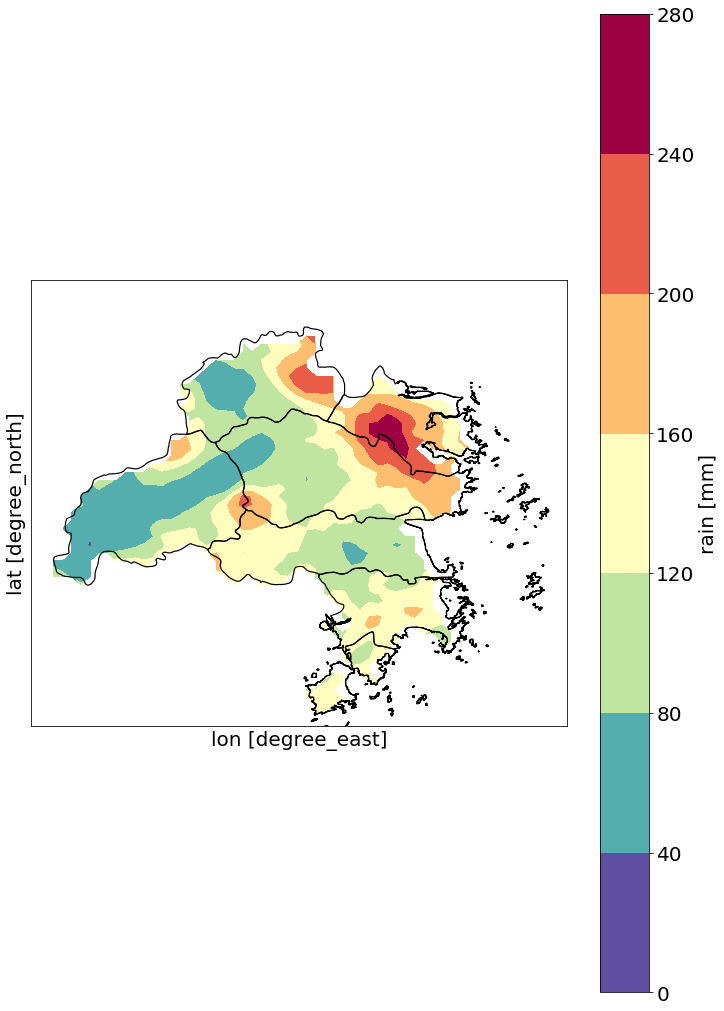

In [77]:
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
m = Basemap(llcrnrlon=120.2,
    llcrnrlat=28,
    urcrnrlon=122,
    urcrnrlat=29.5,
    resolution = None, 
    projection = 'cyl')
fig = plt.figure(figsize=[12,18]) 
ax = fig.add_subplot(111)
filepath = "/home/liyuan3970/Data/test_demo/matplotlib/"
filepath2 = "/home/liyuan3970/study_demo/met_plot/Basemap/"
filepath3 = "/home/liyuan3970/3DVAR_retrive_radar_wind_from_typhoon1909/ncl/precipation/"
# ds = xr.open_dataset(filepath + 'src/share/share/EC-Interim_monthly_2018.nc')
ds = xr.open_dataset(filepath3 + 'pre.nc')
lat = ds.lat
lon = ds.lon
data = ds.rain #(ds['t2m'][0,::-1,:] - 273.15) # 把温度转换为℃

precip_da = add_shape_coord_from_data_array(data, filepath2+"taizhou.shp", "test")
awash_da = precip_da.where(precip_da.test<7, other=np.nan)
cs = awash_da.plot.contourf(ax=ax, cmap='Spectral_r')
# cs = precip_da.plot.contourf(ax=ax, cmap='Spectral_r')
# cs = data.plot.contourf(ax=ax, cmap='Spectral_r')
filepath = "/home/liyuan3970/study_demo/met_plot/Basemap/"
m.readshapefile(filepath+'taizhou','taizhou',color='k',linewidth=1.2)
precip_da.test.shape
# awash_da.plot()
# data.plot()
# print(awash_da)
print(awash_da.shape)
print(data.shape)